# Look at different emission lines and calculate some ratios

First we load up the data as in the `01-extract-subregions` notebook, except that we now use the Peter Zeidler cube:

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube

In [3]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "PeterZeidler" / "DATACUBE_FINAL_fwhm_cor.fits"
cube = Cube(str(fitsfilepath))

Make a summed spectrum and an (H alpha + continuum) image

In [4]:
sp0 = cube.sum(axis=(1, 2))
im_ha = cube.select_lambda(6560.0, 6575.0).sum(axis=0)

And tell seaborn to make the graph labels more readable.

In [5]:
sns.set_context("talk")

## The density-sensitive  [S II] doublet at 6716, 6731 Å

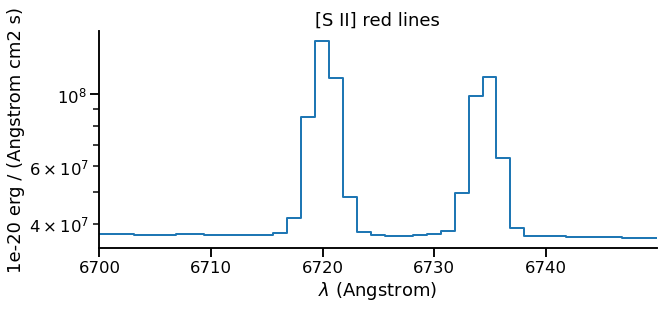

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
sp0.subspec(6700.0, 6750.0).plot(ax=ax, linewidth=2)
ax.set(
    yscale="log",
    title="[S II] red lines",
)
sns.despine()

Find background continuum values.

In [7]:
im_c1 = cube.select_lambda(6710.0, 6715.0).mean(axis=0)
im_c2 = cube.select_lambda(6725.0, 6730.0).mean(axis=0)
im_c6716 = (im_c1 + im_c2) / 2.0
im_c3 = cube.select_lambda(6740.0, 6745.0).mean(axis=0)
im_c6731 = (im_c3 + im_c2) / 2.0

The following was a hack to try and resolve the negative intensity problem in the ESO cube.  But it shouldn't be necessary here. In principle, all these values should turn out positive because the PZ cube does not suffer from the sky oversubtraction problem:

In [8]:
im_c6716_00 = im_c6716.data.min()
im_c6731_00 = im_c6731.data.min()
im_sii16_00 = cube.select_lambda(6715.0, 6725.0).sum(axis=0).data.min()
im_sii31_00 = cube.select_lambda(6730.0, 6740.0).sum(axis=0).data.min()
im_c6716_00, im_c6731_00, im_sii16_00, im_sii31_00

(0.0, 0.0, 108.95647048950195, 139.35368728637695)

So, the only subtraction we will do is the continuum

In [9]:
im_sii16_bgsub = (cube.select_lambda(6715.0, 6725.0) - im_c6716).sum(
    axis=0
)

im_sii31_bgsub = (cube.select_lambda(6730.0, 6740.0) - im_c6731).sum(
    axis=0
)

Text(0.5, 1.0, '[S II] 6716 + 6731 brightness')

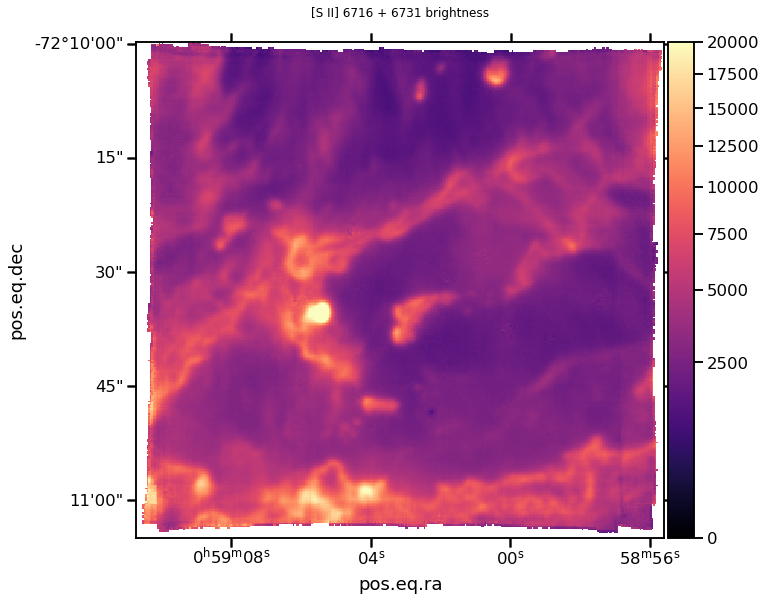

In [10]:
fig = plt.figure(figsize=(10, 10))
(im_sii16_bgsub + im_sii31_bgsub).plot(
    vmin=0.0,
    vmax=20000.0,
    use_wcs=True,
    cmap="magma",
    scale="sqrt",
    colorbar="v",
)
fig.axes[0].set_title(
    label="[S II] 6716 + 6731 brightness",
    pad=25,
    fontsize="large",
)

So this is different from the original version in that the brightness does not go so low. In the next section, we will see how good the zero point really is

### Correcting the zero point by matching the line ratio in the low-density limit

We will break out pandas and seaborn and plot some correlations:

In [11]:
import pandas as pd

In [12]:
sns.set_color_codes()

In [13]:
m = im_sii31_bgsub.data + im_sii16_bgsub.data < 20000.0
m = m & ~im_ha.mask
df = pd.DataFrame(
    {
        "6716": im_sii16_bgsub.data[m],
        "6731": im_sii31_bgsub.data[m],
    }
)

We have made a dataframe with two columns, one for 6716 and one for 6731.  We select only those up to a certain brightness, and eliminate the pixels around the border where there is no data.  Somehow, most of our images have lost their mask at this point, but `im_ha` still has it.  We have to remember that the mask is True when the data *are* masked, that is, bad.  Whereas I want a mask `m` for where the data are good, which is why I had to invert it: `~im_ha.mask`

Text(0.5, 0.98, 'Correlation between 6716 and 6731 brightness')

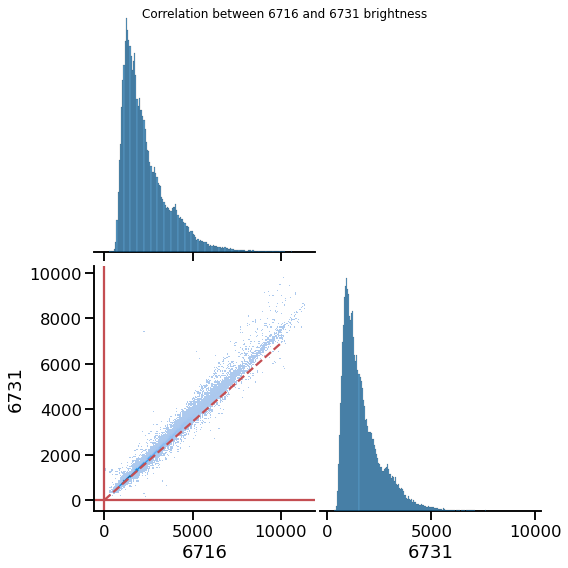

In [14]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, 1e4], [0, 1e4 / 1.45], "--", color="r")
g.fig.suptitle("Correlation between 6716 and 6731 brightness")

I am plotting a corner plot with the histograms of the two brightnesses plus the joint correlation.  We can see that the relation is closely linear at low brightness, and seems headed for the origin, which is a good sign.

Text(0.5, 0.98, 'Correction to 6716 and 6731 brightnesses')

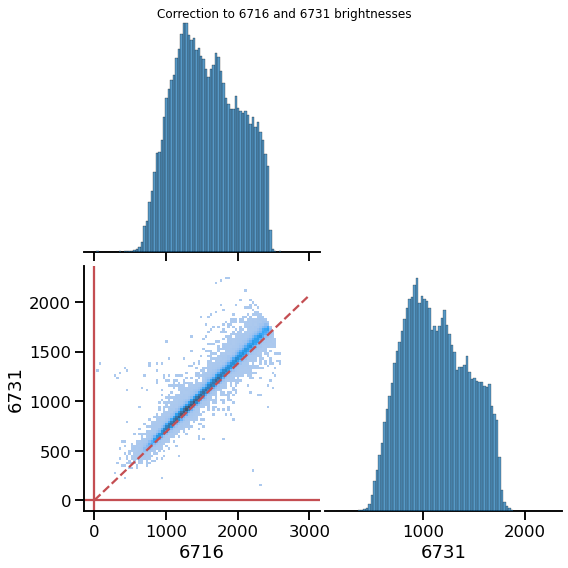

In [28]:
max_bright = 3000.0
m = np.hypot(im_sii31_bgsub.data, im_sii16_bgsub.data) <  max_bright
m = m & ~im_ha.mask
df = pd.DataFrame(
    {
        "6716": im_sii16_bgsub.data[m] + 0,
        "6731": im_sii31_bgsub.data[m] + (0 / 1.45) + 0,
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, max_bright], [0, max_bright / 1.45], "--", color="r")
g.fig.suptitle("Correction to 6716 and 6731 brightnesses")

To be honest, this looks fine. So this is good for the PZ cube so far. So, we comment out the following since there is no need to do any corrections:

In [29]:
# im_sii16_bgsub += 120
# im_sii31_bgsub += 120 / 1.45 + 165

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


Text(0.5, 1.0, '[S II] 6716 / 6731 ratio')

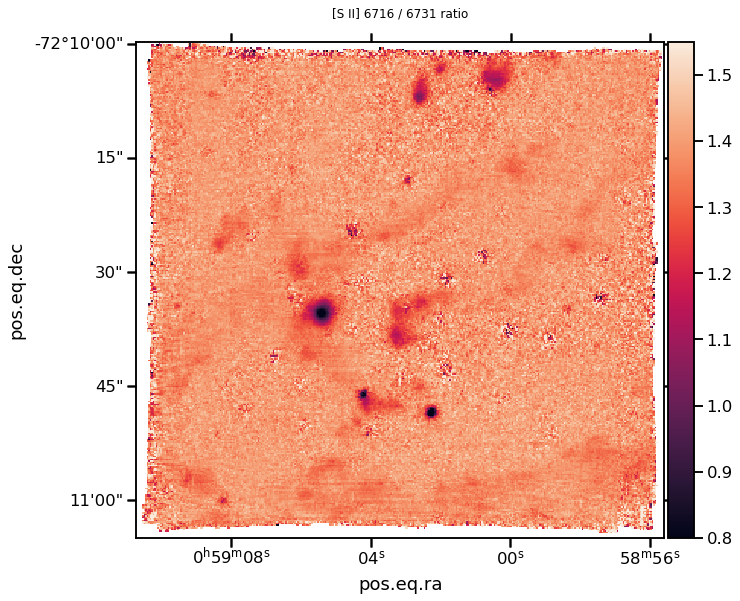

In [30]:
fig = plt.figure(figsize=(10, 10))
(im_sii16_bgsub / im_sii31_bgsub).plot(
    vmin=0.8,
    vmax=1.55,
    use_wcs=True,
    cmap="rocket",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    label="[S II] 6716 / 6731 ratio",
    pad=25,
    fontsize="large",
)

So, there is quite a lot of apparent density variation.  The density seems to be positively correlated with surface brightness, which is to be expected on physical grounds. This is better behaved than the ESO cube in the low brightness regions

We will now investigate that in detail via the histograms.

Text(0.5, 0.98, 'High end of 6716 and 6731 brightness distributions')

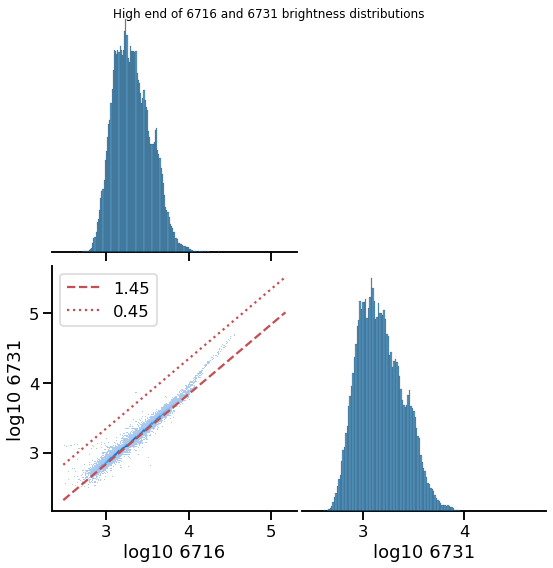

In [40]:
max_bright = 15e4
min_bright = 300.0
m = (im_sii31_bgsub.data < max_bright) & (im_sii16_bgsub.data < max_bright)
m = m & (im_sii31_bgsub.data > min_bright) & (im_sii16_bgsub.data > min_bright)
m = m & ~im_ha.mask
df = pd.DataFrame(
    {
        "log10 6716": np.log10(im_sii16_bgsub.data[m]),
        "log10 6731": np.log10(im_sii31_bgsub.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].plot(
    np.log10([min_bright, max_bright]),
    np.log10([min_bright / 1.45, max_bright / 1.45]),
    "--",
    color="r",
    label="1.45",
)
g.axes[1, 0].plot(
    np.log10([min_bright, max_bright]),
    np.log10([min_bright / 0.45, max_bright / 0.45]),
    ":",
    color="r",
    label="0.45",
)
g.axes[1, 0].legend()
g.fig.suptitle("High end of 6716 and 6731 brightness distributions")

So, here we are looking at the bright end of the distributions on a logarithmic scale from 1000 to 150,000 in summed brightness of 6716 and 6731.

The brightness distributions look approximately log-normal and the correlation is good across the whole range.  There is clear evidence of curving away from the low-density limit of the ratio at high brightness.  The low-density limit is plotted as the red dashed line and the high-density limit is the red dotted line.  The points never get anywhere near the high-density limit.

Text(0.5, 0.98, '[S II] 6716/6731 ratio versus summed brightness')

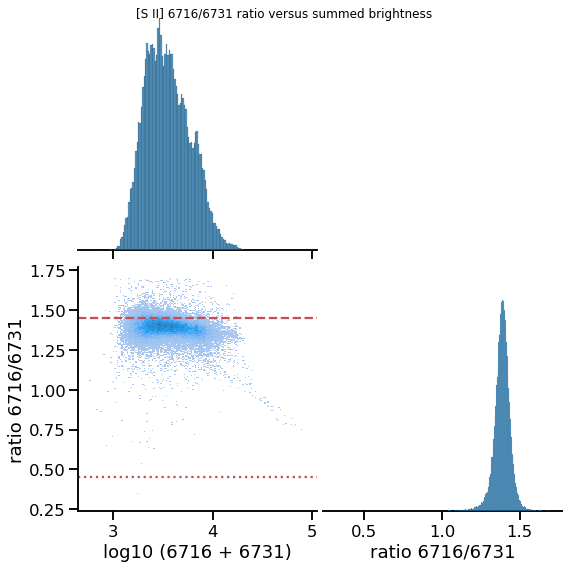

In [41]:
max_bright = 1e6
min_bright = 100.0
sum_sii = im_sii31_bgsub.data + im_sii16_bgsub.data
r_sii = im_sii16_bgsub.data / im_sii31_bgsub.data

m = sum_sii < 2 * max_bright
m = m & (sum_sii > 2 * min_bright)
m = m & ~im_ha.mask
m = m & np.isfinite(r_sii) & (r_sii > 0.3) & (r_sii < 1.7)

df = pd.DataFrame(
    {
        "log10 (6716 + 6731)": np.log10(sum_sii[m]),
        "ratio 6716/6731": r_sii[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axhline(1.45, ls="--", color="r")
g.axes[1, 0].axhline(0.45, ls=":", color="r")
g.fig.suptitle("[S II] 6716/6731 ratio versus summed brightness")

Now, we plot the joint distribution of the ratio and the sum.  This shows more clearly the reduction in ratio at high brightness.

[Text(0.5, 0, '[S II] ratio: 6716 / 6731'),
 Text(0, 0.5, 'CDF'),
 Text(0.5, 1.0, 'Cumulative $n_\\mathrm{e}$ distribution, partitioned by [S II] brightness')]

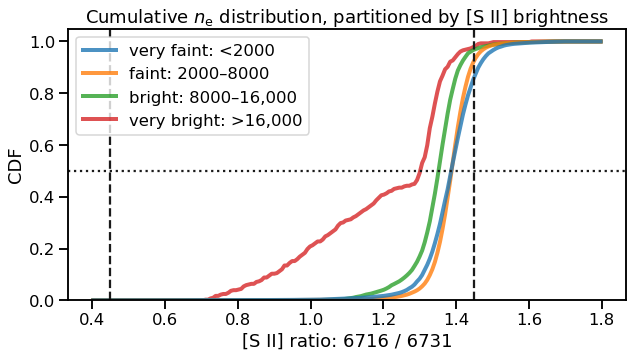

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))

# Partition pixels into 4 groups according to brightness
mpart01 = sum_sii < 2000.0
mpart02 = (sum_sii >= 2000.0) & (sum_sii < 8000.0)
mpart03 = (sum_sii >= 8000.0) & (sum_sii < 16000.0)
mpart04 = sum_sii >= 16000.0

sns.histplot(
    {
        "very faint: <2000": r_sii[m & mpart01],
        "faint: 2000–8000": r_sii[m & mpart02],
        "bright: 8000–16,000": r_sii[m & mpart03],
        "very bright: >16,000": r_sii[m & mpart04],
    },
    cumulative=True,
    binrange=(0.4, 1.8),
    bins=200,
    stat="probability",
    common_norm=False,
    element="poly",
    fill=False,
    alpha=0.8,
    linewidth=4,
)
ax.axvline(0.45, ls="--", color="k")
ax.axvline(1.45, ls="--", color="k")
ax.axhline(0.5, ls=":", color="k")
ax.set(
    xlabel="[S II] ratio: 6716 / 6731",
    ylabel="CDF",
    title="Cumulative $n_\mathrm{e}$ distribution, partitioned by [S II] brightness",
)

Finally, we calculate the cumulative distribution of the ratios for four different brightness classes.

For the faintest partition (blue line), the noise is dominant, which is why the distribution is broad and encroaches slightly into the forbidden region ($R > 1.45$ – the low-density and high-density limits are shown by vertical dashed lines). Less than was the case for the ESO cube however, 
and the median value is a fair bit less than 1.45. 

As we pass to the brighter and brighter partitions (orange, green, red lines), then the CDF 
first becomes steeper, but without the median changing. This is a suign that the noise is decreasing, but the density not necessarily increasing. But then for > 8000, we do get the median point moving to the left, indicating higher densities.

For the brightest partition (red line), the median value is about 1.3, which corresponds to a density of about 200 pcc. The orange line, on the other hand has a median of about 1.4, which is a density of about 30 pcc. *We should use pyneb to invert the ratio properly.*

It will be interesting to compare the distribution of $n$ with the distribution of brightness.

## [N II] lines

So, first, we can try and find the correction for [N II] 6548 and 6583.  They have the advantage that the ratio should be constant.




In [47]:
im_blue_cont = cube.select_lambda(6540.0, 6545.0).mean(axis=0)
im_red_cont = cube.select_lambda(6555.0, 6560.0).mean(axis=0)
im_6548_cont = (im_blue_cont + im_red_cont) / 2.0
im_6548_bgsub = (cube.select_lambda(6545.0, 6555.0) - im_6548_cont).sum(axis=0)


im_blue_cont = cube.select_lambda(6575.0, 6580.0).mean(axis=0)
im_red_cont = cube.select_lambda(6590.0, 6595.0).mean(axis=0)
im_6583_cont = (im_blue_cont + im_red_cont) / 2.0
im_6583_bgsub = (cube.select_lambda(6580.0, 6590.0) - im_6548_cont).sum(axis=0)

Text(0.5, 1.0, '[N II] 6548 + 6583 brightness')

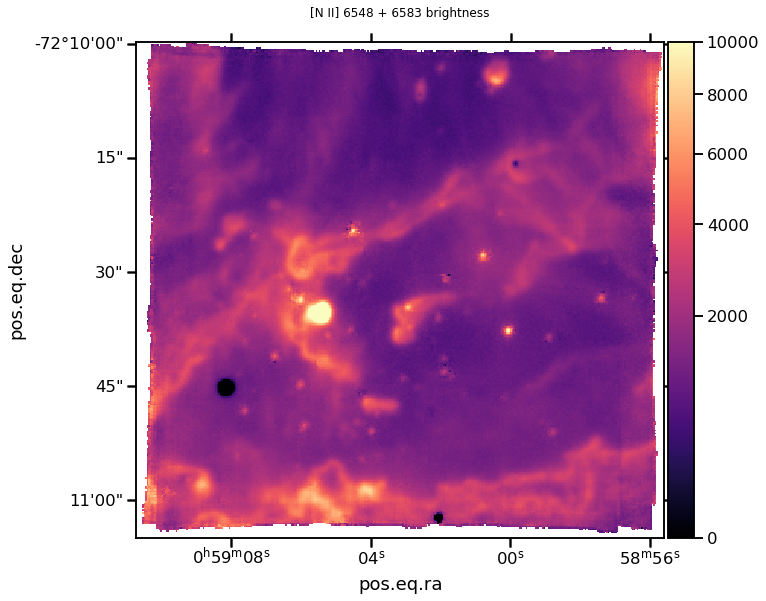

In [49]:
fig = plt.figure(figsize=(10, 10))
(im_6583_bgsub + im_6548_bgsub).plot(
    vmin=0.0,
    vmax=10000.0,
    use_wcs=True,
    cmap="magma",
    scale="sqrt",
    colorbar="v",
)
fig.axes[0].set_title(
    label="[N II] 6548 + 6583 brightness",
    pad=25,
    fontsize="large",
)

So, apart for some stars, the intensity stays positive, which is good

Text(0.5, 0.98, 'Correlation between 6548 and 6583 brightness')

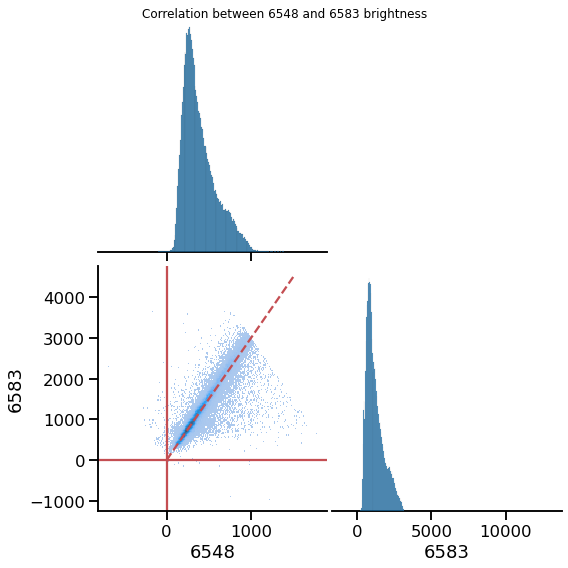

In [50]:
bright_max = 1500.0
nii_sum = 3 * im_6548_bgsub.data + im_6583_bgsub.data
m = (nii_sum < 4 * bright_max) & (nii_sum > 0)
m = m & ~im_ha.mask
df = pd.DataFrame(
    {
        "6548": im_6548_bgsub.data[m],
        "6583": im_6583_bgsub.data[m],
    }
)

g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, bright_max], [0, bright_max * 3], "--", color="r")
g.fig.suptitle("Correlation between 6548 and 6583 brightness")

So this is fine. No need to do the tedious corrrections that we did before.

In [51]:
cube.mask.shape

(3801, 326, 347)

In [52]:
m = np.array(im_6583_bgsub.data) < -3 * 180
m.sum(), m.sum() / np.product(m.shape)

(92, 0.000813281236187479)

In [53]:
mmm = np.repeat(m[None, :, :], cube.data.shape[0], axis=0).astype(float)
mmm.sum(), mmm.sum() / np.product(mmm.shape)

(349692.0, 0.000813281236187479)

In [54]:
sp_faint = np.average(cube.data, weights=mmm, axis=(1, 2))

In [55]:
sp1 = sp0.clone()

In [56]:
sp1.data = sp_faint
sp1.info()

[INFO] 3801 Spectrum (no name)
[INFO] .data(3801) (1e-20 erg / (Angstrom cm2 s)), no noise
[INFO] wavelength: min:4599.94 max:9349.94 step:1.25 Angstrom


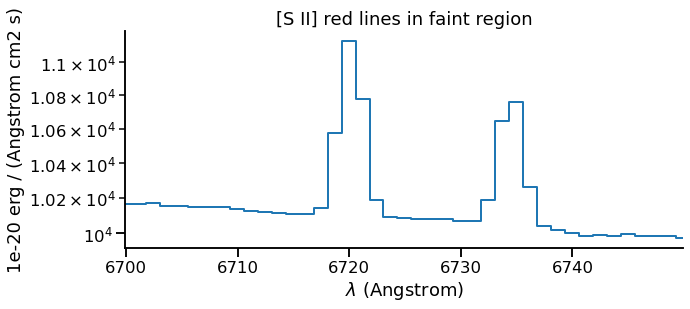

In [57]:
fig, ax = plt.subplots(figsize=(10, 4))
sp1.subspec(6700.0, 6750.0).plot(ax=ax, linewidth=2)
ax.set(
    yscale="log",
    title="[S II] red lines in faint region",
)
sns.despine()

In [58]:
cube.mask_selection?

## Other lines

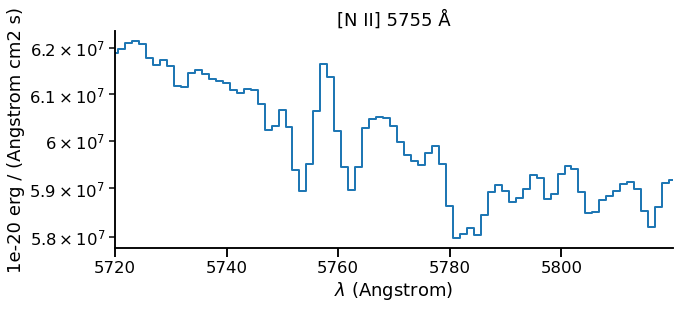

In [59]:
fig, ax = plt.subplots(figsize=(10, 4))
sp0.subspec(5720.0, 5820.0).plot(ax=ax, linewidth=2)
ax.set(
    yscale="log",
    title="[N II] 5755 Å",
)
sns.despine()

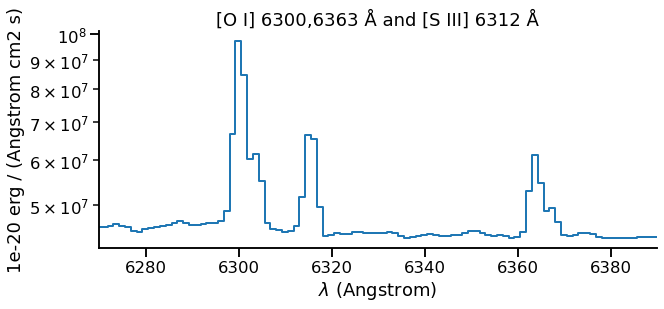

In [60]:
fig, ax = plt.subplots(figsize=(10, 4))
sp0.subspec(6270.0, 6390.0).plot(ax=ax, linewidth=2)
ax.set(
    yscale="log",
    title="[O I] 6300,6363 Å and [S III] 6312 Å",
)
sns.despine()

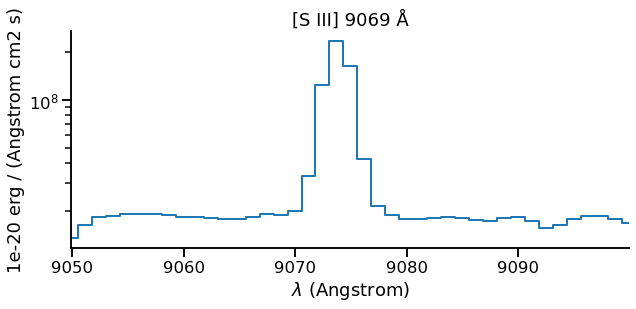

In [61]:
fig, ax = plt.subplots(figsize=(10, 4))
sp0.subspec(9050, 9100).plot(ax=ax, linewidth=2)
ax.set(
    yscale="log",
    title="[S III] 9069 Å",
)
sns.despine()

In [62]:
im_c6312 = cube.select_lambda(6320.0, 6340.0).mean(axis=0)
im_c2 = cube.select_lambda(9065.0, 9070.0).mean(axis=0)
im_c3 = cube.select_lambda(9080.0, 9085.0).mean(axis=0)
im_c9069 = (im_c3 + im_c2) / 2.0

In [63]:
im_siii6312_bgsub = (cube.select_lambda(6310.0, 6320.0) - im_c6312).sum(axis=0)
im_siii9069_bgsub = (cube.select_lambda(9070.0, 9080.0) - im_c9069).sum(axis=0)

No need to correct these brightnesses

In [64]:
# im_siii6312_bgsub += 150.0
# im_siii9069_bgsub -= im_siii9069_bgsub.data.min()

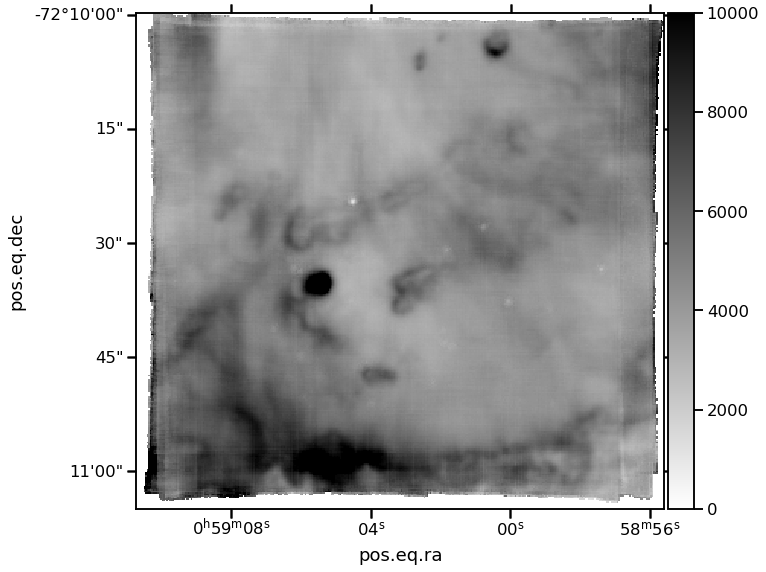

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))
im_siii9069_bgsub.plot(
    vmin=0.0,
    vmax=10000.0,
    use_wcs=True,
    cmap="gray_r",
    scale="linear",
    colorbar="v",
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


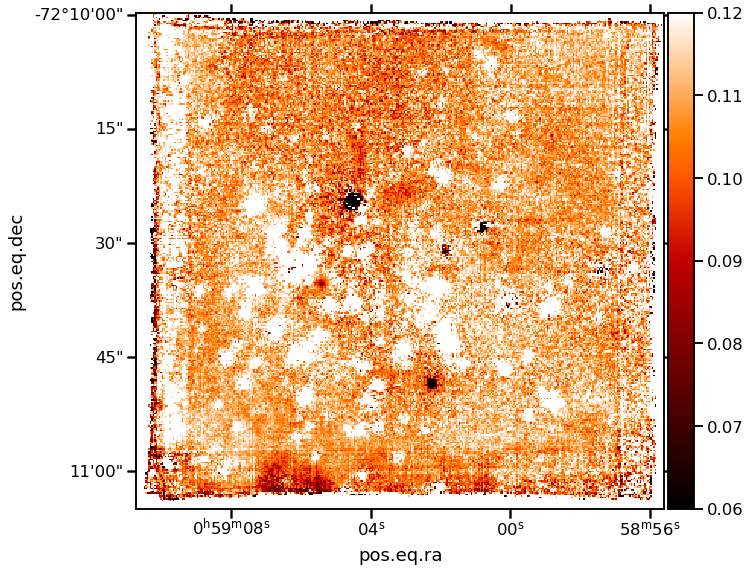

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
(im_siii6312_bgsub / im_siii9069_bgsub).plot(
    vmin=0.06,
    vmax=0.12,
    use_wcs=True,
    cmap="gist_heat",
    scale="linear",
    colorbar="v",
)

A lot of this structure is due to reddeneing, especially along the bottom edge. But still, the veariation is much less than we saw before, which is encouraging.

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


[Text(0.5, 1.0, '[S III] 9069 / [S II] 6731')]

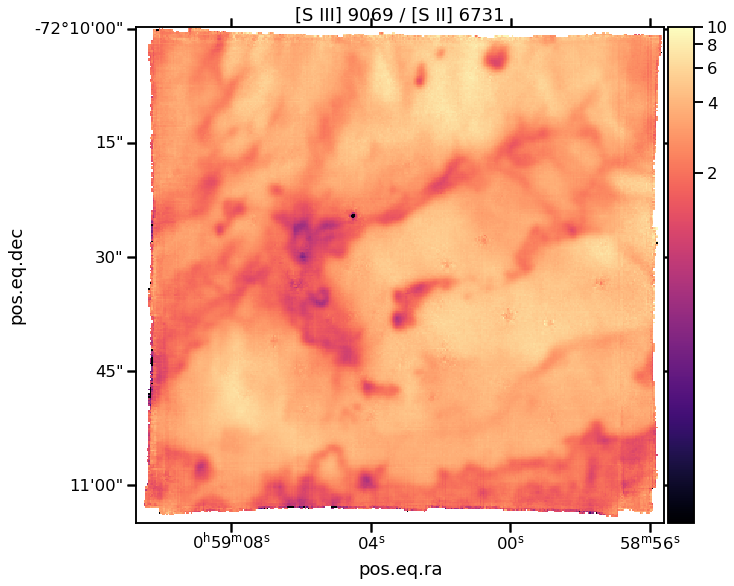

In [71]:
fig = plt.figure(figsize=(10, 10))
(im_siii9069_bgsub / im_sii31_bgsub).plot(
    vmin=0.8,
    vmax=10.0,
    use_wcs=True,
    cmap="magma",
    scale="log",
    colorbar="v",
)
ax = fig.axes[0]
ax.set(
    title="[S III] 9069 / [S II] 6731",
)

This is much better than before too. The ratio gets high in the high-ionization places we expect it to get high, not just in random faint patches.